# Biblical and Apocryphal Citations in Sermon Marginalia 

In [400]:
import sys
sys.path.append('../')
from lib.visualization import * 
from lib.dictionaries.authors import * 
from lib.standardization import * 
from collections import Counter
import pandas as pd
sermons_metadata = pd.read_csv("../assets/sermons.csv")
excluded = ['B07519','A87349','A30293', 'A30435'] # Welsh language 
sermons = sorted(sermons_metadata["id"])
# 4237 sermons in total 

In [3]:
import json,re

def read_data(tcpID): 
    with open(f'../assets/encoded/{tcpID}.json','r') as file:
        encodings, citations, sent_info = json.load(file)
    return encodings, citations, sent_info

def get_tcpIDs(prefix): 
    return [x for x in sermons if prefix in x]

In [422]:
import json
def read_citations(tcpID): 
    with open(f'../assets/encoded/{tcpID}.json','r') as file:
        text,info = json.load(file)
    c_count = 0
    output = []
    for sentence in text:
        s_idx, t_idx, is_note, encodings, citations, outliers, replaced = sentence 
        s_idx = str(s_idx)
        sermon, paragraph = info[s_idx][0], info[s_idx][2]
        for c_idx, c in citations.items(): 
            rep = replaced[int(c_idx)]
            if re.search(r'^he$|^am$|^time$|$the\^|^tyme$|^ti\^|^i\^|^Apol$|^ne$|^te$|^ti$|^tb$|^ac$',rep.split(" ")[0]): continue
            if re.search(r"^\w+ \d+ , \d+$",rep): 
                c = [f"{c[0]}.{c[1].split(' ')[1]}"]
        
            c_count += len(c)
            output.append({'tcpID':tcpID, 
                            'sermon': sermon,
                            'paragraph': paragraph,
                            'sentence': s_idx,
                            'index': t_idx, 
                            'citation': rep,
                            'decomposed': "; ".join(c),
                            'marginal': is_note})
        for c_idx, c in outliers.items(): 
            output.append({'tcpID':tcpID, 
                            'sermon': sermon,
                            'paragraph': paragraph,
                            'sentence': s_idx,
                            'index': t_idx, 
                            'citation': c,
                            'decomposed': "",
                            'marginal': is_note})
        
        tokens = " ".join([x[0] for x in encodings])
        only_verses = re.findall(r"(.*?)\b([Vv]er[.se]*) ([^A-Za-z]+)",tokens)
        only_verses.extend(re.findall(r"(.*?)\b([Vv][.]*) ([^A-Za-z]+)",tokens))
        if len(only_verses) >0: 
            for v in only_verses: 
                if not re.search(r"\d+",v[-1]): continue
                output.append({'tcpID':tcpID, 
                            'sermon': sermon,
                            'paragraph': paragraph,
                            'sentence': s_idx,
                            'index': t_idx, 
                            'citation': f"{" ".join(v[0].split(' ')[-2:])} {v} {v[2]}",
                            'decomposed': "",
                            'marginal': is_note})
    print(tcpID, c_count)
    return output 

In [ ]:
# save all citations
import csv
all_citations = []
for idx, tcpID in enumerate(sermons): 
    all_citations.extend(read_citations(tcpID))

In [424]:
with open("../outputs/citationsA0-A25248.csv","w+") as outfile: 
    writer = csv.DictWriter(outfile, fieldnames=all_citations[0].keys())
    writer.writeheader()
    writer.writerows(all_citations)

In [ ]:
import pandas as pd
import re
citation_info = pd.read_csv("../outputs/citations.csv")
citations = {}
tcpIDs = citation_info['tcpID']
for idx, tcpID in enumerate(tcpIDs):
    if tcpID not in citations: 
        citations[tcpID] = [[],[]]
    else: 
        replaced = citation_info['citation'][idx].split(" ")
        if re.search(r'^he$|^am$|^time$|$the\^|^tyme$|^ti\^|^i\^|^Apol$|^ne$|^te$|^ti$|^tb$|^ac$',replaced[0]): continue

        decomposed = citation_info['decomposed'][idx]
        if isinstance(decomposed,float): continue
        decomposed = decomposed.split("; ")
        book = decomposed[0].split(" ")[0]
        if book == "Ibidem" and len(citations[tcpID][0]) > 0: 
            # address ibidem problem; still need to address the verse/ver problem 
            prior = citations[tcpID][0][-1].split(" ")
            if re.search(r"\d|\^",prior[0]): 
                book = prior[0] + " " + prior[1]
            else: 
                book = prior[0] 
            priornum = prior[1].split(".")
            for d, decomposed_citation in enumerate(decomposed):
                currnum = decomposed_citation.split(" ")[1]
                if len(priornum) == 2 and len(currnum.split(".")) == 1: 
                    decomposed[d] = f"{book} {priornum[1]}.{currnum}"
                else: 
                    decomposed[d] = f"{book} {currnum}"
        
        if re.search(r"^\w+ \d+ , \d+$",citation_info['citation'][idx]): 
            print(citation_info['citation'][idx])
            decomposed = [f"{decomposed[0]}.{decomposed[1].split(' ')[1]]}"]
        citations[tcpID][0].extend(decomposed)
        locations = []
        if citation_info['marginal'][idx]: 
            location =  "marginal"
        else: location = "in-text"
        citations[tcpID][1].extend([location]*len(decomposed))

# Corruption and Uncertainty 

### Chapter and Verse Level

In [148]:
catalog = {}
for tcpID,cited in citations.items(): 
    cited = cited[0]
    if len(cited) == 0: continue
    for c in cited:
        c = c.split(" ")
        if tcpID not in catalog: 
            catalog[tcpID] = {'only_chapter':0,'verse':0,'corrupted_book':0,'corrupted_ch_only':0,'corrupted_v_only':0,'all_corrupt':0}
        if re.search(r'[\d\^]',c[0]): # numbered book with unknown number
            if c[0] == '^': 
                catalog[tcpID]['corrupted_book'] += 1 
                continue
            book = f"{c[0]} {c[1]}"
            ref = c[2]
        else: 
            book = c[0]
            ref = c[1]
            # if re.search(r"\^",book): 
            #     catalog[tcpID]['corrupted_book'] += 1 
            #     continue
        ref = ref.split(".")
        chapter = ref[0]
        if re.search(r"\*|\^",chapter) and len(ref) < 2: 
            # chapter-only citations with illegible characters 
            catalog[tcpID]['corrupted_ch_only'] += 1 
        elif len(ref) == 2: 
            verse = ref[1] 
            if re.search(r"\*|\^",verse): 
                if re.search(r"\*|\^",chapter): 
                    # both chapter and verse are uncertain 
                    catalog[tcpID]['all_corrupt'] += 1 
                else: 
                    # verse is uncertain 
                    catalog[tcpID]['corrupted_v_only'] += 1 
            else: 
                catalog[tcpID]['verse'] += 1 
        else: 
            catalog[tcpID]['only_chapter'] += 1 

    for tcpID, dict in catalog.items():
        corrupt = dict["all_corrupt"] + dict["corrupted_v_only"] + dict["corrupted_ch_only"] + dict["corrupted_book"]
        total = dict["verse"] + corrupt + dict["only_chapter"]
        corrupt_ratio = 0 
        if total > 0: 
            corrupt_ratio = corrupt/total
        catalog[tcpID]['corrupt_ratio'] = corrupt_ratio 
        catalog[tcpID]['total'] = total
        
    sorted_catalog = sorted(catalog, key= lambda x: (catalog[x]['corrupt_ratio'],
                                                    catalog[x]['total']),reverse=True)

Counts

In [149]:
total = sum(catalog[tcpID]['total'] for tcpID in catalog)
clean_ch = sum(catalog[tcpID]['only_chapter'] for tcpID in catalog)
clean_v = sum(catalog[tcpID]['verse'] for tcpID in catalog)
corrupted_book = sum([dict['corrupted_book'] for dict in catalog.values()])
corrupted_ch = sum([dict['corrupted_ch_only'] for dict in catalog.values()])
corrupted_v = sum([dict['corrupted_v_only'] for dict in catalog.values()])
all_corrupt = sum([dict['all_corrupt'] for dict in catalog.values()])
total_corrupted = corrupted_ch + corrupted_v + all_corrupt + corrupted_book
print(f"{total} total citations, with {total_corrupted} ({round((total_corrupted)/total,ndigits=2)*100}%) corrupted")
print(f"Of uncorrupted book citations, {clean_ch + corrupted_ch} ({round((clean_ch+corrupted_ch)/total,ndigits=4)*100}%) are chapter-level and {clean_v+corrupted_v+all_corrupt} ({round((clean_v+corrupted_v+all_corrupt)/total,ndigits=3)*100}%) are verse-level")
print(f"\t{corrupted_ch} ({round((corrupted_ch)/(clean_ch+corrupted_ch),ndigits=3)*100}%) chapter-only citations are corrupted")
print(f"\t{corrupted_v} ({round((corrupted_v)/(clean_v+corrupted_v+all_corrupt),ndigits=2)*100}%) verse citations are corrupted")
print(f"\t{all_corrupt}  ({round((all_corrupt)/(clean_v+corrupted_v+all_corrupt),ndigits=3)*100}%) citations are corrupted in both chapter and verse")
print(f"Of numbered book citations, {corrupted_book} ({round((corrupted_book)/total,ndigits=4)*100}%) are corrupted")

777861 total citations, with 9046 (1.0%) corrupted
Of uncorrupted book citations, 135523 (17.419999999999998%) are chapter-level and 641307 (82.39999999999999%) are verse-level
	2375 (1.7999999999999998%) chapter-only citations are corrupted
	5165 (1.0%) verse citations are corrupted
	475  (0.1%) citations are corrupted in both chapter and verse
Of numbered book citations, 1031 (0.13%) are corrupted


In [150]:
not_corrupted = []
low_corruption = []
high_corruption = []
for tcpID in sorted_catalog: 
    if catalog[tcpID]['corrupt_ratio'] == 0: 
        not_corrupted.append(tcpID)
    elif catalog[tcpID]['corrupt_ratio'] < 0.1: 
        low_corruption.append(tcpID)
    elif catalog[tcpID]['corrupt_ratio'] > 0.4: 
        high_corruption.append(tcpID)
print(len(not_corrupted), "texts without corrupted citations",len(low_corruption),"texts with a small proportion of corrupted citations")
print(len(high_corruption), "texts with a high ratio of corrupted citations")
print(len(sorted_catalog) - (len(not_corrupted) + len(low_corruption) + len(high_corruption)),'texts with a moderate ratio of corrupted citations')

2556 texts without corrupted citations 1437 texts with a small proportion of corrupted citations
5 texts with a high ratio of corrupted citations
96 texts with a moderate ratio of corrupted citations


Save stats to csv

In [151]:
import csv
outfile = open(f"../outputs/citation_stats.csv","w+")
writer = csv.DictWriter(outfile, fieldnames=["tcpID", "only_chapter","verse","corrupted_book","corrupted_ch_only","corrupted_v_only","all_corrupt","corrupt_ratio","total"])
writer.writeheader()
for tcpID in sorted_catalog: 
    dict = catalog[tcpID]
    dict['tcpID'] = tcpID
    writer.writerow(dict)
outfile.close()

# Visualizations 

In [232]:
def get_citations(tcpIDs, loc="all"): 
    tcpIDs = {k:None for k in tcpIDs}
    all_books = {}
    all_chapters = {}
    all_verses = {}
    for tcpID,cited in citations.items(): 
        if tcpID not in tcpIDs: continue
        if len(cited[0]) == 0: continue
        if loc != "all" and cited[1][0] != loc:  
            continue
        cited = cited[0]
        for c in cited: 
            c = c.split(" ")
        
            if re.match(r'[\d\^]',c[0]): 
                # numbered book with unknown number
                if c[0] == '^':  
                    continue
                book = f"{c[0]} {c[1]}"
                ref = c[2]
            else: 
                book = c[0]
                ref = c[1]
            
            if book not in all_books: 
                all_books[book] = []
            all_books[book].append(tcpID)

            ref = ref.split(".")
            chapter = ref[0]
            if '*' not in chapter and "^" not in chapter: 
                key = f"{book} {chapter}"
                if key not in all_chapters: 
                    all_chapters[key] = []
                all_chapters[key].append(tcpID)
                if len(ref) == 2: 
                    verse = ref[1]
                    if '*' not in verse and "^" not in verse: 
                        key = f"{book} {chapter}.{verse}"
                        if key not in all_verses: 
                            all_verses[key] = []
                        all_verses[key].append(tcpID)
    return all_books, all_chapters, all_verses

In [229]:
def bar(orientation,data,title,color,labels,figx,figy):
    plt.figure(figsize = (figx, figy))
    if orientation == 'horizontal': 
        plt.barh(data[0],data[1],color=color)
    else: 
        plt.bar(data[0],data[1],color=color)
    plt.title(title, fontsize=20)
    plt.xlabel(labels[0], fontsize=15)
    plt.xticks(fontsize=12)
    plt.ylabel(labels[1], fontsize=15)
    plt.yticks(fontsize=10)
    plt.show()

In [124]:
aut = 'Fenner, William, 1600-1640'
all_books, all_chapters,all_verses = get_citations(aut_tcpIDs[aut])

In [233]:
in_text_books, in_text_chapters,in_text_verses = get_citations(tcpIDs,"in-text")
marg_books, marg_chapters,marg_verses = get_citations(tcpIDs,"marginal")
all_books, all_chapters,all_verses = get_citations(tcpIDs)

In [ ]:
def visualize(title, color, labels, dictionary): 
    x,y = [],[]
    dictionary = {k:len(v) for k,v in dictionary.items() }
    print(sum(dictionary.values()))
    counts = sorted(dictionary.items(), key=lambda x:x[1],reverse=True)
    print(counts[:26])
    for word,freq in reversed(counts[:26]): 
        x.append(word)
        y.append(freq)
    bar('horizontal',(x,y),title,color,(labels[0],labels[1]),8,10)

# visualize('Most Commonly Cited Books in the Text','lightgrey',('Frequency','Book'),in_text_books)
# visualize('Most Commonly Cited Books in the Margin','lightgrey',('Frequency','Book'),marg_books)
# visualize('Most Commonly Cited Books','lightgrey',('Frequency','Book'),all_books)

# visualize('Most Commonly Cited Chapters','lightgrey',('Frequency','Chapter'),all_chapters)
# visualize('Most Commonly Cited Chapters in the Margin','lightgrey',('Frequency','Chapter'),marg_chapters)
# visualize('Most Commonly Cited Chapters in the Text','lightgrey',('Frequency','Chapter'),in_text_chapters)

visualize('Most Commonly Cited Verses','lightgrey',('Frequency','Verse'),all_verses)
visualize('Most Commonly Cited Verses in the Margin','lightgrey',('Frequency','Verse'),in_text_verses)
visualize('Most Commonly Cited Verses in the Text','lightgrey',('Frequency','Verse'),marg_verses)



## Verse over time 

In [358]:
import numpy as np
dates = sermons_metadata["date"]
subjects = sermons_metadata["subject_headings"]
all_subjects = {}
titles = {}
orig_authors = {}
pubplace = {}
tcpID_dates = {}
for idx,s in enumerate(subjects): 
    tcpID = sermons_metadata['id'][idx]
    titles[tcpID] = sermons_metadata['title'][idx]
    orig_authors[tcpID] = sermons_metadata['authors'][idx]
    pubplace[tcpID] = sermons_metadata['pubplace'][idx]
    all_subjects[tcpID] = [_.strip('.') for _ in s.split("; ")]
    date = sermons_metadata['date'][idx]
    if "-" in date: 
        date = date.split("-")[0]
    tcpID_dates[tcpID] = date
    


In [243]:
dictionary = all_verses
num_sermons = {k:len(set(v)) for k,v in dictionary.items()}
num_sermons = sorted(num_sermons.items(),key=lambda x:x[1],reverse=True)
visualize('','lightgrey',('Frequency','Chapter'),num_sermons)

[('John 3.16', 289), ('Romans 8.28', 279), ('Matthew 11.28', 273), ('Psalms 1.2', 273), ('Philippians 3.8', 273), ('Isaiah 9.6', 268), ('Psalms 1.3', 265), ('Galatians 2.20', 264), ('2 Corinthians 4.17', 262), ('2 Corinthians 5.20', 261), ('Hebrews 12.14', 258)]


In [297]:
def verse_over_time(verses):
    results = {}
    for tcpID, cited in citations.items(): 
        date = tcpID_dates[tcpID]
        locations = cited[1]
        decomposed = cited[0]
        for idx, citation in enumerate(decomposed): 
            if citation in verses: 
                if date not in results: 
                    results[date] = {}
                if tcpID not in results[date]: 
                    results[date][tcpID] = [] 
                results[date][tcpID].append(locations[idx])
    print(len(results))
    visualize_verse_over_time(verses, results) 
    return results

def visualize_verse_over_time(verses, results): 
    marg, text = [],[]
    sermons, years = [],[]
    for date in sorted(results): 
        marg_count, text_count = 0,0
        num_sermons = 0
        for tcpID, locations in results[date].items(): 
            num_sermons += 1 
            locations = Counter(locations)
            if "marginal" in locations: 
                marg_count += locations["marginal"]        
            if "in-text" in locations: 
                text_count += locations["in-text"]
        years.append(int(date))
        marg.append(marg_count)
        text.append(text_count)
        sermons.append(num_sermons)

    plt.figure(figsize = (15, 10))
    plt.bar(years,marg,color="lightgrey",label="Marginal")
    plt.bar(years,text,bottom=marg,color="darkgrey",label="In-Text")
    plt.scatter(years,sermons,color="black",label="Number of Books")
    if len(verses) <= 6: 
        plt.title(f"{', '.join(verses)}", fontsize=20)
    plt.xlabel("Publication Year", fontsize=15)
    plt.xticks(np.arange(min(years),max(years), 10.0), fontsize=12)
    plt.ylabel("Frequency", fontsize=15)
    plt.yticks(fontsize=10)
    plt.legend()
    plt.show()

125


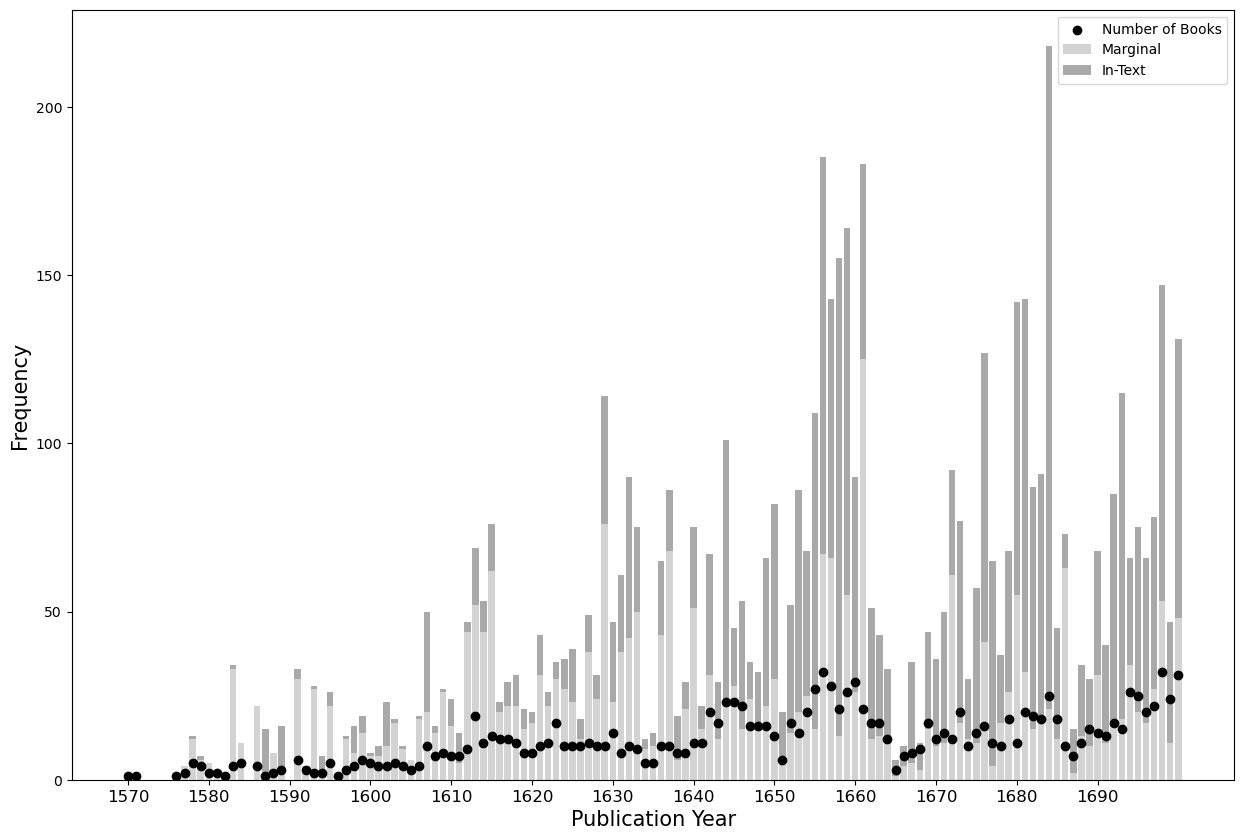

In [367]:
# verse_over_time(["Genesis 12.1"])
# results = verse_over_time(["Genesis 9.25"])
# verse_over_time(["Romans 8.28"])
# verse_over_time(["2 Timothy 3.16"])

# results = verse_over_time(["Genesis 2.18","Deuteronomy 24.1","Deuteronomy 24.2",
#                  "Matthew 5.31","Matthew 5.32","1 Corinthians 7.10"])
# verse_over_time(['Psalms 137.9'])
# results = verse_over_time(["2 Corinthians 3.6"])
# results = verse_over_time(["Colossians 3.1", "Colossians 3.2"])
from lib.dictionaries.charity_citations import *
bible_charity = [re.sub(r":",".",x) for x in bible_charity]
results = verse_over_time(bible_charity)
# for verse in bible_charity: 
#     results = verse_over_time([verse])

In [368]:
tcpIDs = []
for date, dictionary in results.items(): 
    tcpIDs.extend(dictionary.keys())
subjects = []
exclude = ['Sermons, English','17th century','Sermons','Bible','Early works to 1800','16th century']
for tcpID in tcpIDs: 
    for s in all_subjects[tcpID]: 
        if s not in exclude: 
            subjects.append(s)
print(Counter(subjects).most_common())

[('N.T', 327), ('O.T', 253), ('Funeral sermons', 184), ('Church of England', 112), ('Fast-day sermons', 62), ('Christian life', 50), ('England', 45), ('History', 44), ('Great Britain', 40), ('Commentaries', 37), ('God', 24), ('Religious aspects', 23), ('Jesus Christ', 23), ('Controversial literature', 22), ('Christianity', 20), ('Sermons, American', 20), ("Lord's Supper", 18), ('Civil War, 1642-1649', 16), ('No Keywords', 15), ('Death', 14), ('Judgment Day', 14), ('Conduct of life', 13), ('Sin', 13), ('Salvation', 13), ('Faith', 13), ('Love', 12), ('Charity', 12), ('Grace (Theology)', 12), ('Catholic Church', 11), ('Visitation sermons', 11), ('Biblical teaching', 11), ('Repentance', 10), ('Theology, Doctrinal', 9), ('Church of Scotland', 8), ('Church and state', 8), ('Justification', 7), ('Soul', 7), ('Prayer', 7), ('Criticism, interpretation, etc', 7), ('Dissenters, Religious', 7), ('Plague', 6), ("Lord's prayer", 6), ('Theology', 6), ('Congregational churches', 6), ('Society of Frien

In [323]:
dictionary = {}
# for date,item in results.values(): 
#     for key, value in item.items(): 
        # dictionary[key] = len(value)
dictionary = {k:len(v) for k,v in results.items()}
print(sorted(dictionary.items(), key=lambda x:x[1],reverse=True)[:11])

[(1688, 3), (1694, 3), (1650, 2), (1682, 2), (1642, 2), (1613, 2), (1654, 2), (1692, 2), (1681, 2), (1683, 2), (1649, 1)]


In [336]:
for k, v in results.items(): 
    if "A14760" in v.keys(): 
        print(k, v)

1652 {'A14760': ['marginal', 'in-text', 'marginal']}


In [329]:
tcpIDs = []
target_date = 1642
for date, dictionary in results.items(): 
    if date == target_date:
        tcpIDs.extend(dictionary.keys())
subjects = []
exclude = ['Sermons, English','17th century','Sermons','Bible','Early works to 1800','16th century']
for tcpID in tcpIDs: 
    print(pubplace[tcpID],titles[tcpID],all_subjects[tcpID])
#     for s in all_subjects[tcpID]: 
#         if s not in exclude: 
#             subjects.append(s)
# print(Counter(subjects).most_common())

London An explanation of the generall Epistle of Saint Iude. Delivered in one and forty sermons, by that learned, reverend, and faithfull servant of Christ, Master Samuel Otes, parson of Sowthreps in Norfolke. Preached in the parish church of Northwalsham, in the same county, in a publike lecture. And now published for the benefit of Gods church, by Samuel Otes, his sonne, minister of the Word of God at Marsham ['Bible', 'N.T', 'Jude', 'Commentaries', 'Early works to 1800']
London Ten sermons preached I. Ad clerum. 3. II. Ad magistratum. 3. III. Ad populum. 4. By Robert Saunderson Bachellor in Diuinitie, sometimes fellow of Lincolne Colledge in Oxford. ['Sermons, English', '17th century']


## Misc

In [ ]:
# for tcpID, dict in catalog.items():
#     corrupt_verses = dict["all_corrupt"] + dict["corrupted_v_only"]
#     corrupt_chapters = dict["corrupted_ch_only"]
#     total_verses = dict["verse"]+corrupt_verses
#     total_chapters = dict["only_chapter"]+corrupt_chapters
#     if total_verses > 0: 
#         v_ratio = corrupt_verses/total_verses
#     if total_chapters > 0: 
#         c_ratio = corrupt_chapters/total_chapters
#     catalog[tcpID]['corrupt_ch_ratio'] = c_ratio 
#     catalog[tcpID]['corrupt_v_ratio'] = v_ratio 
# sorted_catalog = sorted(catalog, key= lambda x: (catalog[x]['corrupt_ch_ratio'], 
#                                                 catalog[x]['corrupt_v_ratio']))
# for tcpID in reversed(sorted_catalog): 
#     print(catalog[tcpID])

In [108]:
for item in formatting_outliers: 
    if len(item.split(" ")) > 2: 
        print(item)

amos 8 4 5-11
nehemiah 2 4-4 4-4 9-5 19-6 14-13 14-22-29
nehemiah 1 8-6 14-13 14-22-29-31
john 19 1-6-15
acts 14 14 15-8
revelation 7 7 8-10 11
11 4, 5, 7 8, 20, 21, 33-34
acts 2 24 32 3 15, 26 4 10 5 30 13-30, 33
john 5 24 3-18
hebrews 10 32-34 11 24-26
onepeter onepeter 4 12-19 3 14-17
twothessalonians 3 7 9-8
psalms 113 5 *-7
psalms 62 11-2-79 12
unknownpeter 2 19 20-26
onecorinthians onecorinthians 5 1 9-11 6 9-18 7 1
leviticus 4 3 29 33-5 6, 7 9 11-9 22-12 6, 8-14 13-16 16
matthew 17 10 11-11 14
psalms 42 3-10-69 19 80 5 6-89 50, 51-123 3, 4
onetimothy 1 4 6-2 7
genesis 30 35-37 13 14-42 1, 2, 3-43 15-47 1, 2, 3
john 14 1 15 11-16 33
onesamuel 20 30 33-22 8
psalms 25-94-55-42 143 2, 3
psalms 62 11-12-79 12
3 24 5, 15-17
revelation 3 5 21-21 7-22 5
90 5, 7, 8,-11
ecclesiasticus 33 5 7-13
jeremiah 9 5 2-8
james 2 5 1-4
twocorinthians 2 17-,
luke 24 9 10-50 51
2 12, 14,-19
onecorinthians onecorinthians 51 9-11 6 9-18 7 1,


In [57]:
# from collections import Counter
# from difflib import SequenceMatcher
# possible_abbrev = []
# for o in outliers: 
#     possible_abbrev.append(o.split(" ")[0]) 

# possible_abbrev = Counter(possible_abbrev).items()
# possible_matches = {k:[] for k in abbrev}
# for word,freq in possible_abbrev:
#     # print(word)
#     # finding possible matches to any of the known abbreviations for each book
#     if word not in abbrev_to_book: 
#         for ab, book in abbrev_to_book.items():
#             similarity = SequenceMatcher(None, ab, word).ratio()
#             if similarity >= 0.8:
#                 possible_matches[book].append((word,freq))
#                 break

In [58]:
# clean_format = []
# for book, variants in possible_matches.items(): 
#     for v,freq in variants:
#         clean_format.append(f"{book}: {v} {freq}\n") 
#     clean_format.append("\n")
# with open(f"../assets/possible_variants_2.txt","w+") as file: 
#     file.writelines(clean_format)

In [ ]:
# with open(f"../assets/possible_variants_2 copy.txt","r") as file: 
#     lines = file.readlines() 
# for line in lines: 
#     line = line.split(" ")
#     b, ab = line[0].strip(":"), line[1]
#     abbrev[b].append(ab)
# count = 0 
# for b,ab_list in abbrev.items(): 
#     print(f"'{b}':")
#     print("[")
#     for ab in sorted(set(ab_list)): 
#         print(f"\t'{ab}',")
#     print(f"],")